**Financial Services Innovation Lab, Georgia Tech
Programming Task for Summer Research**

Sean Liu

sliu750@gatech.edu

May 14, 2024

**Import the necessary packages.**

In [ ]:
from sec_edgar_downloader import Downloader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from typing import List
import os
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')
from nltk.tokenize import sent_tokenize
import torch
from bs4 import BeautifulSoup
import re
import matplotlib.pyplot as plt
import numpy as np

c:\Users\sean\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sean\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sean\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sean\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\sean\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


**Task 1: Download Data from the SEC-EDGAR**

Download SEC 10-K filings of five public firms (specifically Apple, Amazon, Meta, Google, and Microsoft), using Python's sec-edgar-downloader package. The filings are saved to the Downloads folder.

In [2]:
dl = Downloader("Georgia Tech", "sliu750@gatech.edu", "C:/SEAN/CS Projects/Fintech-Assignment/Downloads")

Ask the user to enter a company ticker, and then download SEC 10-K filings of such company, saving the filings to the Downloads folder.

In [4]:
user_ticker = input("Enter a company ticker (e.g. AAPL): ")
dl.get("10-K", user_ticker, download_details=True)

28

**Task 2: Text Analysis**

This function gets all the filenames (ending in ".html") from a given directory and returns those filenames as a list of strings. Note that the .txt files are very hard to read or parse compared to the .html files.

In [3]:
def get_filenames(directory: str) -> List[str]:
    filenames = []
    # Given how the files are structured, os.walk() will find the deepest level in each folder (i.e. the 10-K filings .txt files).
    for root, _, files in os.walk(directory):
        for filename in files:
            if filename.endswith(".html"):
                filenames.append(os.path.join(root, filename))
    return filenames

This function extracts the section of the file specified by filenamethat starts with start_str and ends with end_str. If there are multiple occurrences of start_str or end_str in text, use the last occurrence of end_str and the last occurrence of start_str that is still before the last occurrence of end_str. Additionally, this function ensures that keyword is contained within the string returned.

In [5]:
def extract_section(filename: str, start_str: str, end_str: str):
    # Load the HTML content
    with open(filename, 'r') as file:
        content = file.read()
        
    # Parse the HTML content.
    soup = BeautifulSoup(content, 'lxml')
    text = soup.get_text()
    
    # Remove large spaces (replace multiple spaces with a single space).
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    
    # Convert content to lower case for case-insensitive search.
    lower_text = text.lower()
    lower_start_str = start_str.lower()
    lower_end_str = end_str.lower()
    
    # Find first occurrence of start_str, and keep the last one.
    start_positions = [match.start() for match in re.finditer(re.escape(lower_start_str), lower_text, re.IGNORECASE)]
    if len(start_positions) == 0:
        return None
    start_pos = start_positions[-1]
    
    # Find all occurrences of end_str, and keep the last one.
    end_positions = [match.start() for match in re.finditer(re.escape(lower_end_str), lower_text, re.IGNORECASE)]
    if len(end_positions) == 0:
        return None
    end_pos = end_positions[-1]
    
    return lower_text[start_pos + len(start_str): end_pos]

This code gets the fiscal year of a 10-K filing specified by filename.

In [6]:
def get_fiscal_year(filename: str):
    # Read and process the content of the HTML file
    with open(filename, 'r') as file:
        read_text = file.read()
        
    soup = BeautifulSoup(read_text, 'lxml')
    text = soup.get_text(separator=' ').lower()

    target = 'for the fiscal year ended '
    
    start_index = text.find(target) # finds first occurrence of target 
    if start_index == -1:
        return None 
    
    comma_index = text.find(',', start_index + len(target)) # finds first occurrence of a comma after the first occurrence of target
    if comma_index == -1:
        return None
    
    year_index = comma_index + 2
    year = int(text[year_index: year_index + 4]) # The last 4 characters in trimmed_date is the year (e.g. 2018).
    return year
    
   

This function extracts useful information from a given file.

In [7]:
def extract_useful_information(filename: str):
    # Read the file specified by filename.
    with open(filename, 'r', encoding='utf-8') as file:
        content = file.read()

    # Parse the content.
    soup = BeautifulSoup(content, 'html.parser')
    
    # Get the year of the filing.
    year = get_fiscal_year(filename)
    
    # Get the management's discussion and analysis (Item 7). 
    # This is the core information of the filing- focusing on just this section simplifies the process while retaining as much essential information as possible.
    
    mgmt_discussion_analysis = extract_section(filename, 'Item 7.', 'Item 8.')
    return year, mgmt_discussion_analysis

This function saves text to a file, specified by filename and directory.

In [8]:
def save_to_txt(filename: str, directory: str, text):
    output_file = os.path.join(directory, filename)

    # Check if the file exists- create it if it doesn't.
    if not os.path.exists(output_file):
        with open(output_file, 'w'):
            pass

    # Now write to the file.
    with open(output_file, 'w') as f:
        for item in text:
            if isinstance(item, str):
                f.write(item + '\n')
            elif isinstance(item, dict):
                for key, value in item.items():
                    f.write(f"{key}: {value}\n")

Now summarize and analyze the 10K filings.

In [9]:
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

c:\Users\sean\miniconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [10]:
summarizer = pipeline('summarization', model = 't5-base')
classifier = pipeline("text-classification", model=model, tokenizer=tokenizer)

In [11]:
emotions_list = ['positive', 'negative']

This function finds strongly emotional sentences (positive or negative) in a given text.

In [12]:
def find_emotional_sentences(text: str, emotions: List[str], threshold = 0.8):
    emotional_sentences = {} # dictionary that maps each emotion to a list of sentences that convey such emotion
    for emo in emotions:
        emotional_sentences[emo] = []

    # Tokenize text into individual sentences.
    sentences = nltk.sent_tokenize(text)

    for sent in sentences:
        tokens = tokenizer.encode(sent, add_special_tokens=True)
        chunks = []
        for i in range(0, len(tokens), 400):
            chunk_tokens = tokens[i:i + 400]
            # Decode tokens back to string
            chunk = tokenizer.decode(chunk_tokens, skip_special_tokens=True)
            chunks.append(chunk)

        # Now classify each chunk.
        for chunk in chunks:
            prediction = classifier(chunk)
            # Consider only emotional (i.e. non-neutral) sentences whose prediction score is above the threshold.
            if prediction[0]['label'] != 'neutral' and prediction[0]['score'] > threshold:
                emotional_sentences[prediction[0]['label']].append(sent)

    return emotional_sentences

This function finds all the emotional sentences in the file specified by filename, and returns the number of positive sentences and the number of negative sentences.

In [13]:
def analyze_text(filename: str):
    # Analyze the text of interest (i.e. management's discussion and analysis).
    year, text_of_interest = extract_useful_information(filename)
    
    if text_of_interest is None:
        return year, 0, 1
    
    emotional_sentences = find_emotional_sentences(text_of_interest, emotions_list)
    return year, len(emotional_sentences['positive']), len(emotional_sentences['negative'])

Conduct text analysis using large language model (LLM) packages. The goal is to gather information and generate insights from the 10-K filings of a company.

In [14]:
# This is directory where the 10-K filings will be read from.
user_directory = "C:/SEAN/CS Projects/Fintech-Assignment/Downloads/sec-edgar-filings/" + user_ticker + "/10-K"

In [15]:
# Read files from the directory (specified above).
user_filenames = get_filenames(user_directory)

In [17]:
user_results = []
for file in user_filenames:
    user_results.append(analyze_text(file))

year: 2017
year: 2018


C:\Users\sean\AppData\Local\Temp\ipykernel_4044\2294316350.py:6: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  soup = BeautifulSoup(read_text, 'lxml')


year: 2019


C:\Users\sean\AppData\Local\Temp\ipykernel_4044\3470125653.py:7: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  soup = BeautifulSoup(content, 'lxml')


year: 2020
year: 2021
year: 2022


Token indices sequence length is longer than the specified maximum sequence length for this model (958 > 512). Running this sequence through the model will result in indexing errors


year: 2023
year: 2002
year: 2003
year: 2004
year: 2007
year: 2008
year: 2009
year: 2010
year: 2011
year: 2012
year: 2013
year: 2014
year: 2015
year: 2016
[(2017, 13, 26), (2018, 25, 20), (2019, 4, 13), (2020, 5, 11), (2021, 6, 6), (2022, 2, 8), (2023, 0, 8), (None, 0, 1), (2002, 0, 0), (2003, 0, 0), (2004, 0, 0), (2007, 0, 0), (None, 64, 118), (None, 49, 40), (2008, 58, 24), (2009, 50, 33), (2010, 51, 35), (2011, 50, 34), (2012, 50, 28), (2013, 35, 35), (2014, 43, 38), (2015, 43, 32), (2016, 13, 23)]


Now using the results, construct a visualization, displaying trends that summarize the management's review with respect to each year. 

The x-axis is year, and the y-axis is the ratio of positive sentences to total sentences.

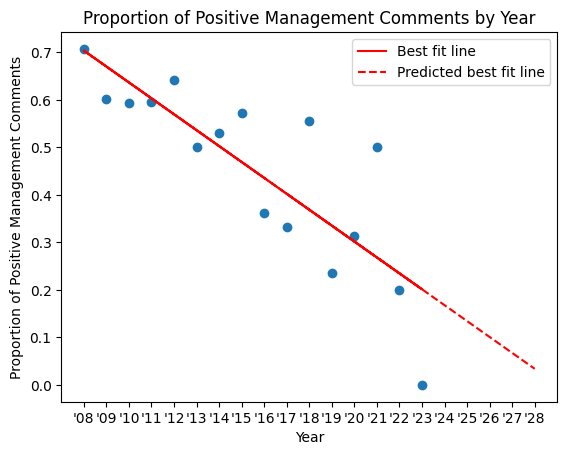

In [34]:
processed_results = []
for result in user_results:
    if (result[0] is not None) and result[2] != 0:
        # In the list obtained above, first element is year, second element is number of positive sentences, and third element is number of negative sentences.
        processed_results.append((result[0], result[1] / (result[1] + result[2])))
        
x_coords = [point[0] for point in processed_results]
y_coords = [point[1] for point in processed_results]

plt.scatter(x_coords, y_coords, marker='o')
plt.title('Proportion of Positive Management Comments by Year')
plt.xlabel('Year')
plt.ylabel('Proportion of Positive Management Comments')

# Calculate (and display) the line of best fit.
coefficients = np.polyfit(x_coords, y_coords, 1) # Polynomial degree of 1 means a straight line of best fit.
line_of_best_fit = np.poly1d(coefficients)
y_fit = line_of_best_fit(x_coords)

# Plot the line of best fit
plt.plot(x_coords, y_fit, label='Best fit line', color='red')

# Predict y-coordinates for up to 5 years into the future
future_years = list(range(max(x_coords) + 1, max(x_coords) + 6))
future_y_coords = line_of_best_fit(future_years)

# Extend the line of best fit to future years
extended_x_coords = x_coords + future_years
extended_y_fit = list(y_fit) + list(future_y_coords)
plt.plot(extended_x_coords, extended_y_fit, label='Predicted best fit line', color='red', linestyle='--')
all_years = list(range(min(x_coords), max(x_coords) + 6))

plt.xticks(all_years, [f"'{str(year)[-2:]}" for year in all_years])
plt.legend()
plt.show()